# Laboratorio 5. Clasificación de tweets usando mineria de texto

integrantes: 

    - Francis Aguilar - 22243 
    - Angela García -22869 
    - Cesar Lopez - 22535

enlace al repositorio: https://github.com/angelargd8/lab5-ds

In [31]:
# !pip install nltk
# !pip install wordcloud
# !pip install emoji

In [32]:
import pandas as pd 
import numpy as np 
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, make_scorer, precision_score, recall_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC


In [33]:
# Descargar stopwords de NLTK
nltk.download("stopwords")
stop_words   = set(stopwords.words("english"))
stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Francis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

# Dataset de tweets

El conjunto de datos está formado por más de 10 500 filas y 5 columnas: 

id: El identificador del tweet

keyword: una palabra clave del tweet, puede estar en blanco 

location: la ubicación desde donde fue enviado el tweet 

text: El texto del tweet 

target: La etiqueta de clasificación que especifica si el tweet se trata de un desastre real (1) o no (0). 

In [34]:
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Analisis exploratorio

In [35]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [37]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [38]:
df.value_counts()

id     keyword  location                       text                                                                                                         target
48     ablaze   Birmingham                     @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C                                                      1         1
49     ablaze   Est. September 2012 - Bristol  We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw                                          0         1
50     ablaze   AFRICA                         #AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi                           1         1
52     ablaze   Philadelphia, PA               Crying out for more! Set me ablaze                                                                           0         1
53     ablaze   London, UK                     On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N                                 0        

In [39]:
#contar valores duplicadosss
df.duplicated().sum()

np.int64(0)

In [40]:
#contar valores nulos
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [41]:
# pass si es keyword nulo, porque es opcional, agregarle un valor por defecto
df["keyword"].fillna("sin keyword", inplace=True)

# colocar no location
df["location"].fillna("sin location", inplace=True)

C:\Users\Francis\AppData\Local\Temp\ipykernel_3372\2483260786.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["keyword"].fillna("sin keyword", inplace=True)
C:\Users\Francis\AppData\Local\Temp\ipykernel_3372\2483260786.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [42]:
#tamanio del dataset
df.shape

(7613, 5)

In [43]:
#tablas de contingencia
#frecuencias absolutas
pd.crosstab(df["keyword"], df["target"]).head(10)


target,0,1
keyword,,
ablaze,23,13
accident,11,24
aftershock,34,0
airplane%20accident,5,30
ambulance,18,20
annihilated,23,11
annihilation,19,10
apocalypse,23,9
armageddon,37,5


El resultado es una tabla con conteos por conbinacion de keyword y target

In [44]:
pd.crosstab(df["keyword"], df["target"], normalize="index").head(10)


target,0,1
keyword,,
ablaze,0.638889,0.361111
accident,0.314286,0.685714
aftershock,1.000000,0.000000
airplane%20accident,0.142857,0.857143
ambulance,0.473684,0.526316
annihilated,0.676471,0.323529
annihilation,0.655172,0.344828
apocalypse,0.718750,0.281250
armageddon,0.880952,0.119048


el resultado de esta tabla de proporcion es que para keyword, que proporcion pertenece a target 0 vs target 1

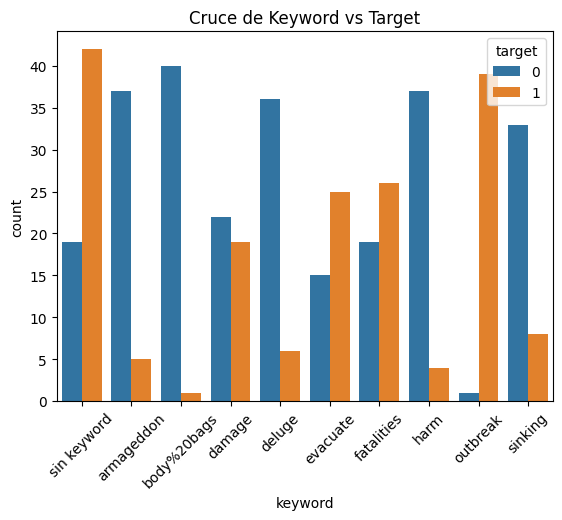

In [45]:
import seaborn as sns

top_keywords = df["keyword"].value_counts().head(10).index
sns.countplot(data=df[df["keyword"].isin(top_keywords)], 
              x="keyword", hue="target")
plt.xticks(rotation=45)
plt.title("Cruce de Keyword vs Target")
plt.show()


Lo que se logra observar es la propocion para pertenece a target 0 o 1. Siendo, la target si el tweet trata de un desastre real cuando es 1 y 0 cuando no lo es. Para cada palabra se nota una gran diferencia de distribución. Y las palabras como armageddon, deluge, harm la mayoria de tweets están en contextos que no son de desastres reales, podrían ser relacionados con contextos humoristicos, ironía o metafóricos. 
Mientras, las keywords más ligadas a los desastres faltales son evacuate, fatalities y outbreak lo que puede que estan más relacionadas a reportes de emergencias reales. 
Y en el caso de los que no tienen keyword, la mayoría parece que están relacionados con desastres reales, pero no es suficiente por dí solo para distinguir desastres.


<Axes: xlabel='target', ylabel='text_length'>

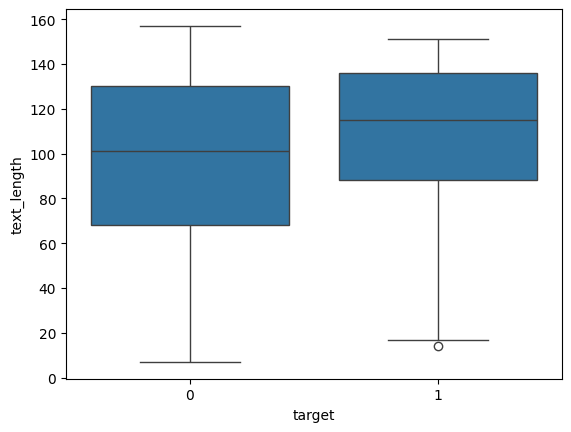

In [46]:
#cruce con variables de texto
df["text_length"] = df["text"].apply(len)
sns.boxplot(x="target", y="text_length", data=df)


En el gráfico de cruce con variables de texto de longitud de texto según la variable, lo que se puede observar es que la media de los tweets que no son de desastre tienen alrededor de una media de 50 caracteres. Mientras, los tweets con target 1, que indican un desastre real tienen una media más alta de 60 cáracteres, lo que puede indicar que los que describen un desastre real suelen ser más largos. Esto puede ser debido a que los tweets de desastres reales tienden a ser más largo porque den contexto como del lugar daños o personas.  

### 3. limpieza y preprocesamiento de los datos

In [47]:
import emoji
import string
import unicodedata

columnas_cat = df.select_dtypes(include=['object']).columns

important_numbers = {"911", "112", "999", "420", "19"}

def clean_text(text):

    text = text.lower()                                # minúsculas
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # quitar URLs
    text = re.sub(r"@\w+", "", text)                    # quitar menciones
    
    text = re.sub(r"#[\w-]+", "", text)                  # quitar hashtags

    text = re.sub(r"\d+", "", text)                       # quitar números

    text = re.sub(r"'\w+", "", text)                      # quitar apostrofes

    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # quitar URLs

    text = emoji.replace_emoji(text, replace="") #quitar emojis, al parecer tambien se puede con  text = re.sub(r"[^\x00-\x7F]+", "", text) 

    #fechas 12/05/2025, 2025-05-12
    text = re.sub(r"\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b", "<date>", text)

    # Horas  12:30, 23:59
    text = re.sub(r"\b\d{1,2}:\d{2}\b", "<time>", text)

    # Cantidades con K, M, % ( 100k, 5%, 2m)
    text = re.sub(r"\b\d+(k|m|%)\b", "<qty>", text)

    # Numeros en general: si es importante, mantenerlo si no, <num>
    def replace_numbers(match):
        num = match.group()
        return num if num in important_numbers else "<num>"

    text = re.sub(r"\b\d+\b", replace_numbers, text)

    #quitar acentos
    text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("utf-8", "ignore")

    text = text.translate(str.maketrans("", "", string.punctuation))  # quitar puntuación
    text = re.sub(r"\s+", " ", text).strip()  # quitar espacios extra

    #quitar la letra U sola, porque no es relevante
    text = re.sub(r"\bU\b|\bu\b", "", text)

    #quitar la palabra via
    text = re.sub(r"\bvia\b", "", text)

    #quitar la palabra amp
    text = re.sub(r"\bamp\b", "", text)

    #tokenizar
    tokens = text.split()
    #quitar stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df[columnas_cat] = df[columnas_cat].applymap(clean_text)
df

C:\Users\Francis\AppData\Local\Temp\ipykernel_3372\4145394944.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columnas_cat] = df[columnas_cat].applymap(clean_text)


,id,keyword,location,text,target,text_length
0,1,sin keyword,sin location,deeds reason may allah forgive us,1,69
1,4,sin keyword,sin location,forest fire near la ronge sask canada,1,38
2,5,sin keyword,sin location,residents asked place notified officers evacua...,1,133
3,6,sin keyword,sin location,people receive evacuation orders california,1,65
4,7,sin keyword,sin location,got sent photo ruby smoke pours school,1,88
...,...,...,...,...,...,...
7608,10869,sin keyword,sin location,two giant cranes holding bridge collapse nearb...,1,83
7609,10870,sin keyword,sin location,control wild fires california even northern pa...,1,125
7610,10871,sin keyword,sin location,utckm volcano hawaii,1,65
7611,10872,sin keyword,sin location,police investigating ebike collided car little...,1,137


## Análisis Exploratorio de Texto 

1. Revisemos las palabras más comunes en target = 1 y 0
2. Visualicemos estas palabras en **nubes de palabras** para entender mejor los patrones.  

In [48]:
# Texto combinado por clase
cols_wc = ["text", "keyword"]  # sin location
target1_words = df.loc[df.target==1, cols_wc].fillna("").agg(" ".join, axis=1).str.cat(sep=" ")
target2_words = df.loc[df.target==0, cols_wc].fillna("").agg(" ".join, axis=1).str.cat(sep=" ")


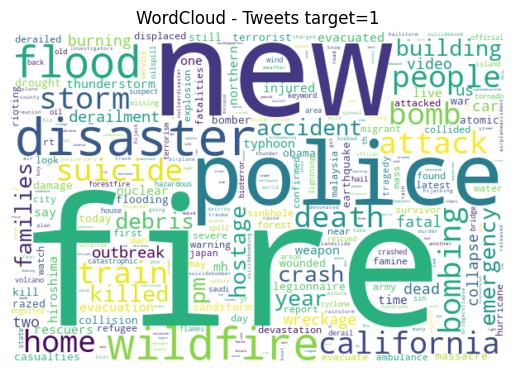

In [49]:
wc_params = dict(width=600, height=400, background_color="white",
                 collocations=False, max_words=300)

wordcloud_pos = WordCloud(**wc_params).generate(target1_words)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Tweets target=1")
plt.show()


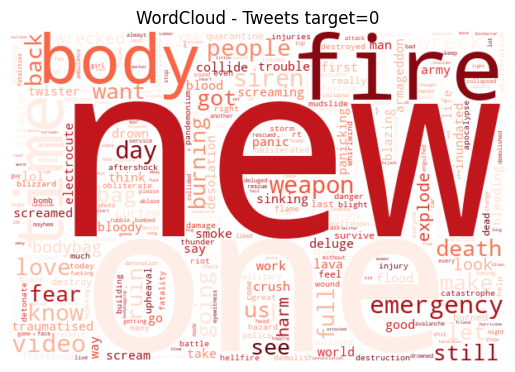

In [50]:
wordcloud_neg = WordCloud(**wc_params, colormap="Reds").generate(target2_words)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Tweets target=0")
plt.show()

En los tweets que sí se refieren a un desastre real (target=1), se observa un predominio de palabras asociadas directamente a eventos catastróficos, como disaster, fire, flood, storm, wildfire, crash, bomb, debris o death. También aparecen términos que se relacionan a instituciones de emergencia, como police, emergency, rescuers y referencias a lugares como California. El lenguaje es objetivo y descriptivo, más cercano a un estilo de noticia o de alerta oficial, enfocado en responder a qué pasó, dónde ocurrió y quiénes se vieron afectados. Esto refleja que los tweets de esta categoría tienden a relatar hechos concretos y verificables.

Por otro lado, los tweets que no corresponden a un desastre real (target=0) muestran un vocabulario distinto. Aunque incluyen algunas palabras asociadas a desastres (fire, flood, weapon, burning), estas suelen estar usadas en contextos figurativos o emocionales. Aparecen términos subjetivos y cotidianos como know, want, see, going, make y expresiones que se pueden relacionar más a lo emocional como bloody, panic, screaming, traumatised. El tono es narrativo, exagerado, más cercano a la opinión personal. 

Para poder ayudar al modelo a predecir de una mejor manera, se hará un análisis de los ngramas para saber también la relación de estas palabras bajo su contexto o en conjunto con otras palabras, aquí es donde se puede respaldar que las palabras como disaster, tambien pueden usarse en contextos más coloquiales como para referirse a una fiesta o a un evento personal. 

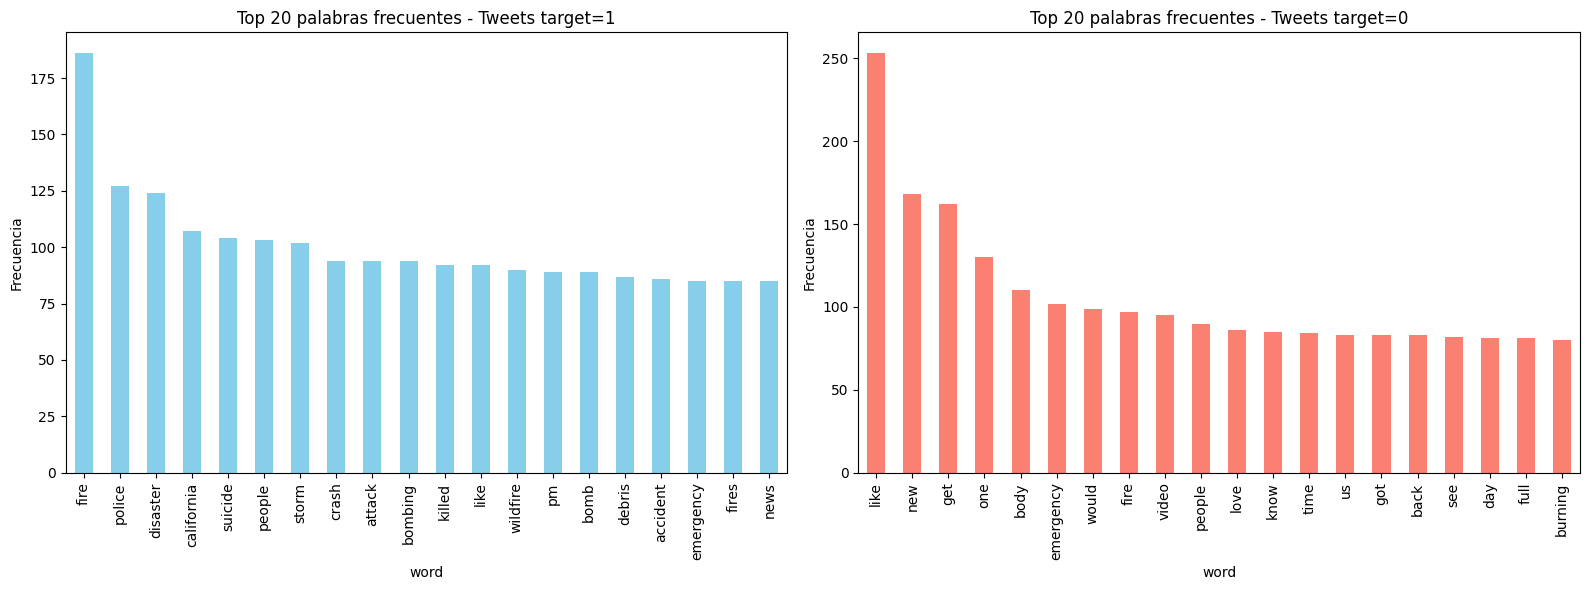

In [52]:
# Histogramas de frecuencias palabras individuales
from collections import Counter
import pandas as pd

target1_counts = Counter(target1_words.split())
target0_counts = Counter(target2_words.split())

df_target1 = pd.DataFrame(target1_counts.most_common(20), columns=['word', 'count'])
df_target0 = pd.DataFrame(target0_counts.most_common(20), columns=['word', 'count'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_target1.plot.bar(x='word', y='count', ax=axes[0], color="skyblue", legend=False)
axes[0].set_title("Top 20 palabras frecuentes - Tweets target=1")
axes[0].set_ylabel("Frecuencia")

df_target0.plot.bar(x='word', y='count', ax=axes[1], color="salmon", legend=False)
axes[1].set_title("Top 20 palabras frecuentes - Tweets target=0")
axes[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


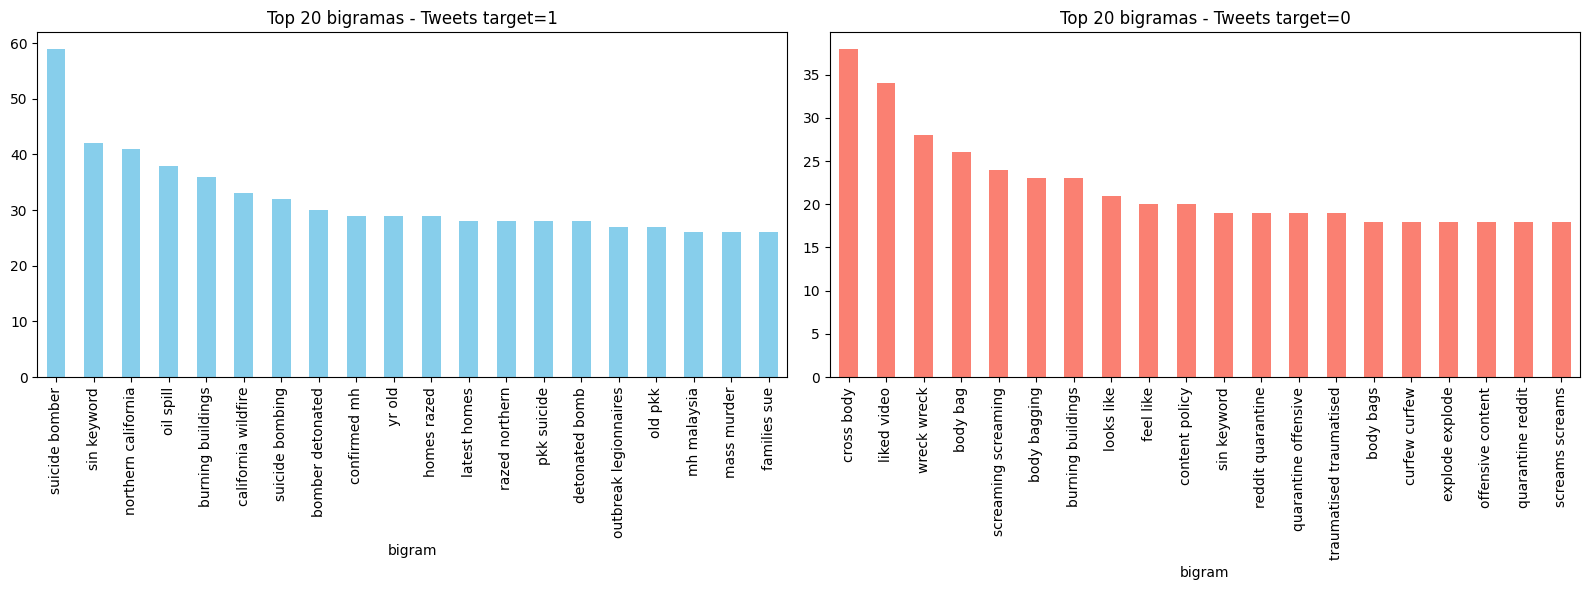

In [53]:
# Histogramas de frecuencias duplas de palabras

vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')

# Target 1
X1 = vectorizer.fit_transform([target1_words])
sum_words1 = X1.toarray().sum(axis=0)
words_freq1 = [(word, sum_words1[idx]) for word, idx in vectorizer.vocabulary_.items()]
df_bigram1 = pd.DataFrame(sorted(words_freq1, key=lambda x: x[1], reverse=True)[:20],
                          columns=['bigram','count'])

# Target 0
X0 = vectorizer.fit_transform([target2_words])
sum_words0 = X0.toarray().sum(axis=0)
words_freq0 = [(word, sum_words0[idx]) for word, idx in vectorizer.vocabulary_.items()]
df_bigram0 = pd.DataFrame(sorted(words_freq0, key=lambda x: x[1], reverse=True)[:20],
                          columns=['bigram','count'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df_bigram1.plot.bar(x='bigram', y='count', ax=axes[0], color="skyblue", legend=False)
axes[0].set_title("Top 20 bigramas - Tweets target=1")

df_bigram0.plot.bar(x='bigram', y='count', ax=axes[1], color="salmon", legend=False)
axes[1].set_title("Top 20 bigramas - Tweets target=0")

plt.tight_layout()
plt.show()


In [54]:
df[df["text"].str.contains("wreck wreck", case=False, na=False)]

,id,keyword,location,text,target,text_length,clean_text
7472,10689,wreck,sin location,wreck wreck wreck wreck wreck wreck wreck wrec...,0,79,wreck wreck wreck wreck wreck wreck wreck wrec...
7487,10709,wreck,sin location,emotions train wreck body train wreck wreck,0,68,emotions train wreck body train wreck wreck


En los tweets clasificados como desastres reales (target = 1) se observa que los bigramas más frecuentes están estrechamente relacionados con acontecimientos de carácter catastrófico. Expresiones como “suicide bomber”, “bomber detonated” y “detonated bomb” remiten a ataques terroristas o explosiones. De manera similar, bigramas como “burning buildings”, “california wildfire” y “oil spill” reflejan desastres naturales e incidentes ambientales, mientras que “mass murder” o “homes razed” refuerzan la idea de violencia y destrucción a gran escala. Este patrón evidencia que el lenguaje de los tweets en esta categoría es predominantemente objetivo, descriptivo y vinculado a situaciones de emergencia verificables.

En los tweets clasificados como no desastres (target = 0) los bigramas muestran un uso del lenguaje más cotidiano. Ejemplos como “liked video”, “reddit quarantine”, “content policy” y “offensive content” se asocian principalmente con interacciones en plataformas sociales, por lo que no se ve una relación directa con emergencias reales. Asimismo, frases como “looks like”, “feel like” o “screaming screaming” corresponden a expresiones subjetivas o figurativas, más próximas a opiniones o emociones personales. Incluso combinaciones aparentemente alarmantes, como “body bag” o “cross body”, en este contexto hacen referencia a elementos de moda o a usos metafóricos, y no a sucesos trágicos.

Mientras los tweets de desastres reales emplean un lenguaje descriptivo y orientado a eventos catastróficos, los tweets no relacionados con desastres se caracterizan por expresiones coloquiales, emocionales y vinculadas a la interacción digital.

En primer lugar, es importante notar que el bigrama parece redundante. En muchos casos, este tipo de repeticiones se generan porque los usuarios en Twitter escriben de forma poco estructurada, repiten palabras para dar énfasis o incluso por errores tipográficos. En el contexto de los tweets no relacionados con desastres, la repetición “wreck wreck” probablemente se utilice de manera figurativa o coloquial, como una forma de exagerar una situación personal, un juego, un evento deportivo o incluso un comentario humorístico, y no para describir un accidente real.

### Creacion de modelo de prediccion 

In [55]:
df

,id,keyword,location,text,target,text_length,clean_text
0,1,sin keyword,sin location,deeds reason may allah forgive us,1,69,deeds reason may allah forgive us
1,4,sin keyword,sin location,forest fire near la ronge sask canada,1,38,forest fire near la ronge sask canada
2,5,sin keyword,sin location,residents asked place notified officers evacua...,1,133,residents asked place notified officers evacua...
3,6,sin keyword,sin location,people receive evacuation orders california,1,65,people receive evacuation orders california
4,7,sin keyword,sin location,got sent photo ruby smoke pours school,1,88,got sent photo ruby smoke pours school
...,...,...,...,...,...,...,...
7608,10869,sin keyword,sin location,two giant cranes holding bridge collapse nearb...,1,83,two giant cranes holding bridge collapse nearb...
7609,10870,sin keyword,sin location,control wild fires california even northern pa...,1,125,control wild fires california even northern pa...
7610,10871,sin keyword,sin location,utckm volcano hawaii,1,65,utckm volcano hawaii
7611,10872,sin keyword,sin location,police investigating ebike collided car little...,1,137,police investigating ebike collided car little...


In [64]:
vectorizer = CountVectorizer(ngram_range=(1,2))  # unigramas y bigramas
X = vectorizer.fit_transform(df["text"])
y = df["target"]


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Reporte de Clasificación:\n")
print(classification_report(y_test, y_pred))

Reporte de Clasificación:

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1318
           1       0.81      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [66]:
cm = confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)

print('Matriz de confusión:\n',cm)
print('Accuracy: ',accuracy)

Matriz de confusión:
 [[1167  151]
 [ 303  663]]
Accuracy:  0.8012259194395797


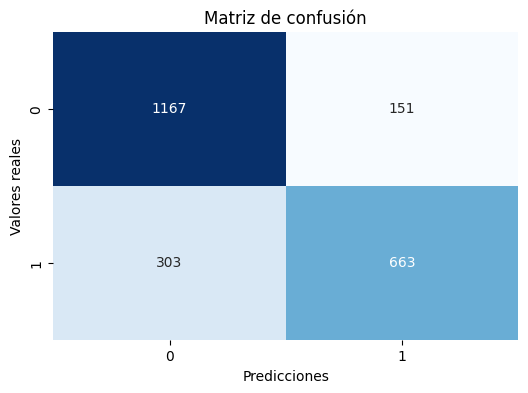

Accuracy: 0.8012259194395797
Precisión: 0.8025980963434053
Recall: 0.8012259194395797
F1-Score: 0.7981574549199746

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84      1318
           1       0.81      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [67]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' si hay varias clases
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generar matriz
cm = confusion_matrix(y_test, y_pred)

# Crear gráfico
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de confusión")
plt.show()

print("Accuracy:", accuracy)
print("Precisión:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Podemos observar que el modelo es relativamente bueno con un accuracy y preciosion del 80%. En cuanto a la clase 0 (no desastre), el modelo obtiene un desempeño más alto: presenta una precisión del 79 %, lo que indica que la mayoría de los tweets que predice como “no desastre” efectivamente lo son. Además, logra un recall del 89 %, lo que significa que identifica correctamente casi 9 de cada 10 tweets que realmente no son desastres. El F1-score de 0.84 refleja un equilibrio bastante sólido entre precisión y cobertura para esta clase. Por otro lado, para la clase 1 (desastre real), los resultados son más modestos. La precisión es del 81 %, lo que implica que, cuando el modelo predice “desastre”, en la mayoría de los casos acierta. Sin embargo, el recall baja al 69 %, lo que indica que el modelo deja escapar aproximadamente 3 de cada 10 tweets que sí son desastres. El F1-score de 0.74 muestra que, aunque el modelo es relativamente confiable cuando detecta un desastre, todavía tiene dificultades para capturar todos los casos reales.

In [68]:

def clean_text_series(series: pd.Series) -> pd.Series:
    def clean_one(t: str) -> str:
        if not isinstance(t, str):
            t = "" if pd.isna(t) else str(t)
        s = t.lower()
        s = re.sub(r"http[s]?://\S+|www\.\S+", " ", s)
        s = re.sub(r"@\w+", " ", s)
        s = re.sub(r"#", " ", s)
        s = re.sub(r"[\U00010000-\U0010ffff]", " ", s)
        s = s.replace("’","'")
        s = re.sub(r"[^a-z0-9\s]", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        return s
    return series.astype(str).apply(clean_one)

pipe = Pipeline([
    ("clean", FunctionTransformer(clean_text_series, validate=False)),
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=40000)),
    ("clf", LinearSVC(random_state=42)),
])

# Asumiendo que tu DataFrame principal se llama df y tiene columnas ['text','target']
X_train, X_val, y_train, y_val = train_test_split(
    df["text"].astype(str), df["target"].astype(int),
    test_size=0.2, random_state=42, stratify=df["target"].astype(int)
)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1(1):", f1_score(y_val, y_pred))
print("F1-macro:", f1_score(y_val, y_pred, average="macro"))
print(classification_report(y_val, y_pred, digits=4))


Accuracy: 0.7846355876559422
F1(1): 0.7461300309597523
F1-macro: 0.7795644453544486
              precision    recall  f1-score   support

           0     0.8056    0.8205    0.8130       869
           1     0.7555    0.7370    0.7461       654

    accuracy                         0.7846      1523
   macro avg     0.7806    0.7787    0.7796      1523
weighted avg     0.7841    0.7846    0.7843      1523



Se diseñó una función de limpieza de texto con el objetivo de normalizar los tweets antes de su representación vectorial. Esta función convierte todos los caracteres a minúsculas y elimina elementos que suelen considerarse ruido en el análisis de texto, como enlaces (URLs), menciones a usuarios, hashtags, emojis y caracteres especiales. Adicionalmente, se homogenizan ciertos símbolos y se reducen los espacios múltiples. Este proceso asegura que los datos textuales se encuentren en una forma más consistente y adecuada para ser procesados por el modelo.

Posteriormente, se construyó un pipeline de procesamiento y clasificación. El pipeline aplica en primer lugar la limpieza de texto, después transforma los tweets en vectores numéricos utilizando TF-IDF con bigramas y unigramas, un umbral mínimo de frecuencia para reducir ruido, y un límite máximo de 40,000 características para controlar la dimensionalidad. Finalmente, los vectores se introducen en un clasificador LinearSVC (Support Vector Machine lineal), un modelo robusto para problemas de clasificación de texto. En conjunto, los resultados del pipeline son consistentes con lo esperado en tareas de clasificación de texto con datos desbalanceados o con ruido en el lenguaje propio de Twitter. Aunque el desempeño general es aceptable, se observa la necesidad de mejorar el recall de la clase positiva (desastres reales)

In [61]:
def clasificar_dataframe(modelo, df_in, text_col='text'):
    X = df_in[text_col].astype(str)
    out = df_in.copy()
    out["pred"] = modelo.predict(X).astype(int)
    return out

df_pred = clasificar_dataframe(pipe, df, text_col="text")

# Guardar archivos
df_pred[ [c for c in ["id","keyword","location","text","target"] if c in df_pred.columns] + ["pred"] ] \
    .to_csv("predicciones_tweets.csv", index=False, encoding="utf-8")

if "id" in df_pred.columns:
    df_pred[["id","pred"]].rename(columns={"pred":"target"}).to_csv("submission.csv", index=False, encoding="utf-8")


En esta sección se implementa una función auxiliar llamada clasificar_dataframe, cuyo propósito es aplicar el modelo entrenado sobre un conjunto de datos completo. La función recibe como entrada el modelo ya ajustado, el DataFrame de interés y el nombre de la columna de texto a clasificar. Posteriormente, genera una copia del DataFrame original y añade una nueva columna denominada pred, que contiene las predicciones del modelo expresadas como enteros (0 = no desastre, 1 = desastre). Esto permite comparar de forma directa las etiquetas originales con las etiquetas predichas, además de facilitar análisis posteriores sobre los errores de clasificación.